In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..//..")
import config
from utils import compute_frames

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

In [3]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
# set device to GPU
dev = "cuda:0"

# History dataset generation

In [5]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [6]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["date"] = pd.to_datetime(deforestation["date"])

## Create grid

In [7]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS), total=len(config.TIME_STEPS)):
    defor_area = (
        deforestation[
            deforestation["date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:46<00:00,  5.60it/s]


In [8]:
time_grid.shape

(258, 3003, 2331)

<Axes: >

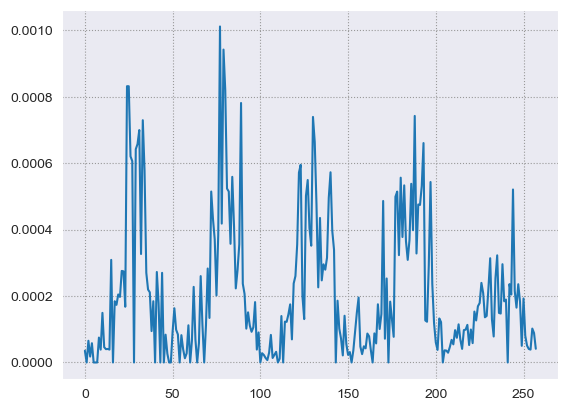

In [9]:
sns.lineplot((time_grid>0).mean(axis=(1,2)))

In [10]:
time_grid[time_grid>0].min()

1.8668610237347164e-15

In [11]:
(time_grid == 0).mean()

0.9997900202772849

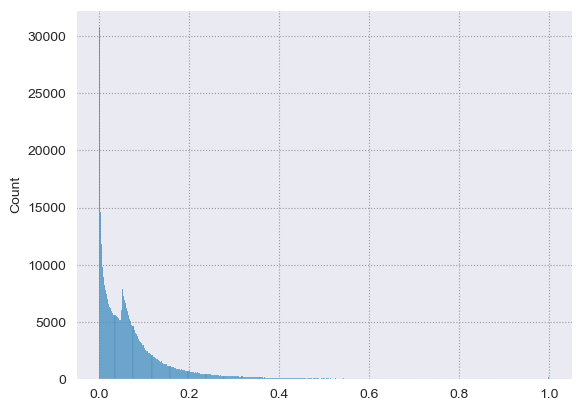

In [12]:
sns.histplot(time_grid[time_grid>0].flatten())
plt.show()

## Past Deforestation

In [13]:
past_defor = pd.read_csv(config.TR_PAST_DEFOR, index_col=0)
print("Shape:", past_defor.shape)
past_defor.head()

Shape: (1485979, 3)


,frame_id,area,date
0,31363,0.048051,2007-12-31
1,31364,0.024607,2007-12-31
2,33694,0.186462,2007-12-31
3,33695,0.113806,2007-12-31
4,36025,0.046768,2007-12-31


In [14]:
past_defor["date"] = pd.to_datetime(past_defor["date"])

In [15]:
frames_idx.shape

(6999993, 4)

In [16]:
past_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS), total=len(config.TIME_STEPS)):
    past_area = (
        past_defor[
            past_defor["date"] <= dt
        ].groupby("frame_id")["area"].sum() +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    past_grid[t, :, :] = past_area.values.reshape(time_grid[0, :, :].shape)

100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [01:44<00:00,  2.47it/s]


In [17]:
# clip on 1.0 (upper bound)
past_grid = past_grid.clip(max=1.0)

In [18]:
past_grid.shape

(258, 3003, 2331)

<Axes: >

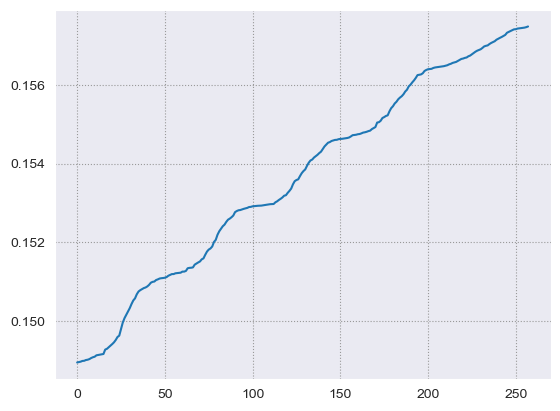

In [19]:
sns.lineplot((past_grid>0).mean(axis=(1,2)))

## IBAMA 

In [20]:
ibama = pd.read_csv(config.TR_IBAMA)

In [21]:
ibama.columns

Index(['frame_id', 'Access_Minut_Beef_2012', 'Access_Minut_City',
       'Access_Minut_soy', 'Access_Minut_soy_p25', 'Access_Minut_wood_2012',
       'garimpos', 'Multas_upto2019', 'Terras_Devolutas', 'TI_Dist',
       'UCPI_dist', 'UCUS_Dist', 'Pasture_Mapbiomas', 'Soybean_Mapbiomas',
       'UCPI_IO', 'UCUS_IO', 'Terras_Devolutas_IO', 'TI_IO'],
      dtype='object')

In [22]:
cols = ['Access_Minut_Beef_2012', 'Access_Minut_City',
       'Access_Minut_soy', 'Access_Minut_soy_p25', 'Access_Minut_wood_2012',
       'garimpos', 'Multas_upto2019', 'Terras_Devolutas', 'TI_Dist',
       'UCPI_dist', 'UCUS_Dist', 'Pasture_Mapbiomas', 'Soybean_Mapbiomas',
       'UCPI_IO', 'UCUS_IO', 'Terras_Devolutas_IO', 'TI_IO']
ib_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for icol, col in tqdm(enumerate(cols), total=len(cols)):
    v = (
        ibama.set_index("frame_id")[col] +\
        pd.Series(0, index=frames_idx.index)
    ).sort_index()
    v = v.fillna(v.mean())
    ib_array[icol, :, :] = v.values.reshape(ib_array[0, :, :].shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.77it/s]


In [23]:
ib_array.shape

(17, 3003, 2331)

In [24]:
ib_array.mean(axis=(1, 2))

array([6.85562305e+02, 2.66465496e+05, 1.18234887e+03, 1.58586288e+03,
       7.07369293e+02, 2.06246754e+00, 2.12181093e-01, 3.17992975e-01,
       4.01327017e-01, 7.72110329e-01, 6.26294951e-01, 5.71402732e-02,
       7.97603881e-04, 9.03787938e-02, 1.56052780e-01, 1.25013982e-01,
       2.28485021e-01])

## Counties data

In [25]:
# counties
frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)

In [26]:
county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
county_data[0, :, :] = (
    frames_county.set_index("frame_id")["populacao"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

county_data[1, :, :] = (
    frames_county.set_index("frame_id")["densidade"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

In [27]:
county_data.shape

(2, 3003, 2331)

In [28]:
county_data.mean(axis=(1,2))

array([2.61956226e+04, 3.24194994e+00])

# Compute frame patches

A patch is squared set of unitary frames. The patch formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [29]:
config.INPUT_BOXES_SIZE = 128

In [30]:
out_condition = "both"  # deforestation | borders | both

bundle_step = 64
patches = []
patches_full = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]

        patches_full.append(iframes.index)
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                patches.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain some deforestation
                patches.append(iframes.index) 

        elif out_condition == "both":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if (out_of_borders_frames < len(iframes)) and (iframes["in_borders"].mean() >= 0.5):
                patches.append(iframes.index) 

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:01<00:00,  2.58s/it]


In [31]:
len(patches[0])

16384

In [32]:
time_grid.shape

(258, 3003, 2331)

In [33]:
# remove patches that represent reduced regions
patches = [b for b in patches if (len(b)==config.INPUT_BOXES_SIZE**2)]

In [34]:
len(patches)

869

In [35]:
patches[0]

Index([   896,    897,    898,    899,    900,    901,    902,    903,    904,
          905,
       ...
       297051, 297052, 297053, 297054, 297055, 297056, 297057, 297058, 297059,
       297060],
      dtype='int64', length=16384)

In [36]:
# remove not used anymore dataframes
del deforestation
del past_defor
del ibama
del frames_county

# Train test split

In [37]:
time_grid.shape

(258, 3003, 2331)

In [38]:
train_time_idx = range(0,156)
val_time_idx = range(104, 206)
test_time_idx = range(154, 258)

train_data = time_grid[train_time_idx, :, :]
val_data = time_grid[val_time_idx, :, :]
test_data = time_grid[test_time_idx, :, :]

In [39]:
print(f"""
train : {config.TIME_STEPS[train_time_idx[52]].date()} -> {config.TIME_STEPS[train_time_idx[-1]].date()}
val   : {config.TIME_STEPS[val_time_idx[52]].date()} -> {config.TIME_STEPS[val_time_idx[-1]].date()}
test  : {config.TIME_STEPS[test_time_idx[52]].date()} -> {config.TIME_STEPS[test_time_idx[-1]].date()}
""")


train : 2020-01-20 -> 2022-01-10
val   : 2022-01-17 -> 2022-12-26
test  : 2023-01-02 -> 2023-12-25



In [40]:
config.TIME_STEPS[-1]

Timestamp('2023-12-25 00:00:00')

# Data Normalization

In [41]:
time_grid.shape

(258, 3003, 2331)

In [42]:
n1 = (train_data <= 1e-18).sum() - ((~frames_idx["in_borders"]).sum() * len(train_time_idx))
n1

642962800

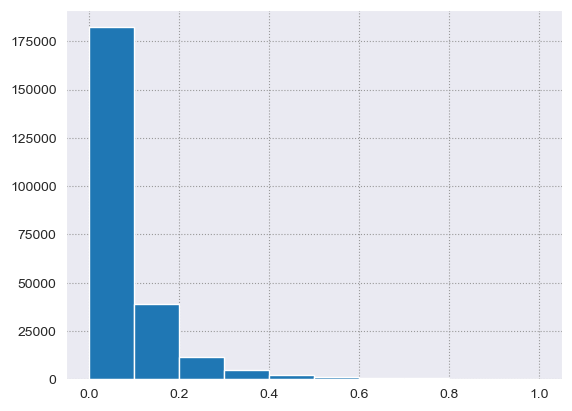

In [43]:
plt.hist(train_data[(train_data > 1e-12)], bins=10)
plt.show()

In [44]:
n2 = (train_data > 1e-12).sum()
n2

243448

In [45]:
imbalance_factor = n1 / n2
imbalance_factor

2641.0683184910126

In [46]:
for i in range(ib_array.shape[0]):
    ib_array[i, :, :] = (ib_array[i, :, :] - ib_array[i, :, :].mean()) / ib_array[i, :, :].std()

In [47]:
norm_pop = (county_data[0, :, :] - np.median(county_data[0, :, :])) / 1e5
norm_den = (county_data[1, :, :] - np.median(county_data[1, :, :])) / 30

county_data[0, :, :] = norm_pop
county_data[1, :, :] = norm_den

# Loss function

In [48]:
# focal loss
from segmentation_models_pytorch.losses import FocalLoss
loss = FocalLoss("binary", gamma=3, reduction="mean").to(dev)

# Dataset & Dataloaders

In [49]:
FUTURE_WINDOW_PRED = 12

In [50]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X, 
        patches, 
        frames_idx,
        county_data=None,
        ibama_data=None,
        past_defor_data=None
    ):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.ibama_data = ibama_data
        self.past_defor_data = past_defor_data

        self.autor_window = 52
        self.future_window = FUTURE_WINDOW_PRED
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window-self.future_window+1)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0]-self.autor_window-self.future_window+1)
        idx_time   = index % (self.X.shape[0]-self.autor_window-self.future_window+1)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        
        # full past deforestation
        input_matrix = self.past_defor_data[
            idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]
        input_matrix = input_matrix.reshape(1, input_matrix.shape[0], input_matrix.shape[1])
        
        # # last 'autor_window' weeks of deforestation
        # input_matrix = self.X[
        #     idx_time:idx_time+self.autor_window, 
        #     idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
        #     idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        # ].sum(axis=0).clip(max=1.0)
        # input_matrix = input_matrix.reshape(1, input_matrix.shape[0], input_matrix.shape[1])
        
        # some 'delta weeks' of deforestation
        lagweeks = [52, 24, 12, 4, 2, 0]
        for i in range(len(lagweeks)-1):
            input_matrix = np.concatenate([
                input_matrix,
                self.X[
                    idx_time+self.autor_window-lagweeks[i]:idx_time+self.autor_window-lagweeks[i+1],
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ].sum(axis=0).clip(max=1.0)\
                .reshape((1, input_matrix.shape[1], input_matrix.shape[2]))
            ])
        
        if self.county_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        
        if self.ibama_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.ibama_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
            
        data = torch.tensor(input_matrix).float().to(dev)

        # get output
        labels = np.zeros(
            (
                idx_frames["x"].max()-idx_frames["x"].min() + 1, 
                idx_frames["y"].max()-idx_frames["y"].min() + 1
            )
        )
        target_idx = np.where(
            self.X[
                idx_time+self.autor_window:idx_time+self.autor_window+self.future_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ].sum(axis=0) > 1e-18
        )
        labels[target_idx] = 1
        labels = torch.tensor(labels).float().to(dev)
        
        return data, labels

In [51]:
train_data.shape, val_data.shape, test_data.shape

((156, 3003, 2331), (102, 3003, 2331), (104, 3003, 2331))

In [52]:
np.random.seed(0)

In [53]:
patches_sample_train = patches
patches_sample_val = patches

# rand_patches_idx = np.random.choice(range(len(patches)), 60)
# patches_sample_train = [patches[idx] for idx in rand_patches_idx]
# patches_sample_val = [patches[idx] for idx in rand_patches_idx]

In [54]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches_sample_train, 
        frames_idx,
        past_defor_data=past_grid,
        county_data=county_data,
        ibama_data=ib_array
    ),
    batch_size=128,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    CustomDataset(
        val_data, 
        patches_sample_val, 
        frames_idx,
        past_defor_data=past_grid,
        county_data=county_data,
        ibama_data=ib_array
    ),
    batch_size=128,
    shuffle=True
)

In [55]:
trainloader.__len__(), valloader.__len__()

(632, 265)

# Baseline Model

Evaluate error without any model

In [56]:
# baseline: all zero
base_train_err = 0
for inputs, labels in tqdm(trainloader):
    y_pred = torch.tensor(-10*np.ones(labels.shape)).to(dev)
    base_train_err += loss(y_pred=y_pred, y_true=labels)
base_train_err = base_train_err / len(trainloader)

print(f"Baseline Error (Train) = {base_train_err:.6f}")

100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [14:41<00:00,  1.39s/it]

Baseline Error (Train) = 0.046882


In [57]:
base_val_err = 0
for inputs, labels in tqdm(valloader):
    y_pred = torch.tensor(-10*np.ones(labels.shape)).to(dev)
    base_val_err += loss(y_pred=y_pred, y_true=labels)
base_val_err = base_val_err / len(valloader)
print(f"Baseline Error (Validation) = {base_val_err:.6f}")

100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [06:08<00:00,  1.39s/it]

Baseline Error (Validation) = 0.052558


# Model Init

In [58]:
def clean_gpu_memory(model):
    del model
    import gc         # garbage collect library
    gc.collect()
    torch.cuda.empty_cache() 

In [59]:
import torch.optim as optim
from torch import nn
from resunet import ResUnet

In [60]:
inputs.shape

torch.Size([99, 25, 128, 128])

In [61]:
in_channels = 25
in_channels

25

In [62]:
# clean_gpu_memory(model)

In [63]:
model = ResUnet(
    channel=in_channels,
    output_dim=1,
    filters=[16, 16, 16, 16] # [16, 32, 64, 128]
).to(dev)
optimizer = optim.Adam(model.parameters())  # lr=1e-5

In [64]:
sum([p.flatten().shape[0] for p in model.parameters()])

68977

# Train loop

In [65]:
# train loop
model.epoch = 0
model.errs = []

In [66]:
def evaluate_model(model, dataloader):
    err = 0
    for inputs, labels in dataloader:
        err += loss(model(inputs), labels).detach()
    err = err / len(dataloader)

    return err

In [67]:
def run_epoch():
    model.epoch += 1
    print(f"\nEpoch {model.epoch}")
    
    train_err = 0
    for inputs, labels in tqdm(trainloader):
        L = loss(model(inputs), labels)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        train_err += L.detach()
    train_err = train_err / len(trainloader)
    
    return train_err


def train(n_epochs):
    for epoch in range(n_epochs):
        
        # train for 1 epoch and compute error
        train_err = run_epoch()

        # compute validation error and save history            
        val_err = evaluate_model(model, valloader)
        model.errs.append([train_err, val_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Validation Loss = {val_err:.6f}")

In [68]:
# train for 10 epochs, saving each model version state
best_val_err = 1e9
for _ in range(7):
    train(1)
    torch.save(model.state_dict(), f"model_checkpoint_{model.epoch}.pt")


Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [13:53<00:00,  1.32s/it]


Epoch 1: Train Loss = 0.004634 | Validation Loss = 0.003679

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [13:58<00:00,  1.33s/it]


Epoch 2: Train Loss = 0.003271 | Validation Loss = 0.003512

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [13:59<00:00,  1.33s/it]


Epoch 3: Train Loss = 0.003100 | Validation Loss = 0.003495

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [13:57<00:00,  1.32s/it]


Epoch 4: Train Loss = 0.002934 | Validation Loss = 0.003658

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [14:00<00:00,  1.33s/it]


Epoch 5: Train Loss = 0.002817 | Validation Loss = 0.003714

Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [13:58<00:00,  1.33s/it]


Epoch 6: Train Loss = 0.002732 | Validation Loss = 0.003860

Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [13:58<00:00,  1.33s/it]


Epoch 7: Train Loss = 0.002670 | Validation Loss = 0.003849


Better than baseline?

In [69]:
(
    float((model.errs[-1][0] - base_train_err) / base_train_err), 
    float((model.errs[-1][1] - base_val_err) / base_val_err)
)

(-0.943048470452164, -0.9267627959729664)

Learning curve

In [70]:
import matplotlib.pyplot as plt

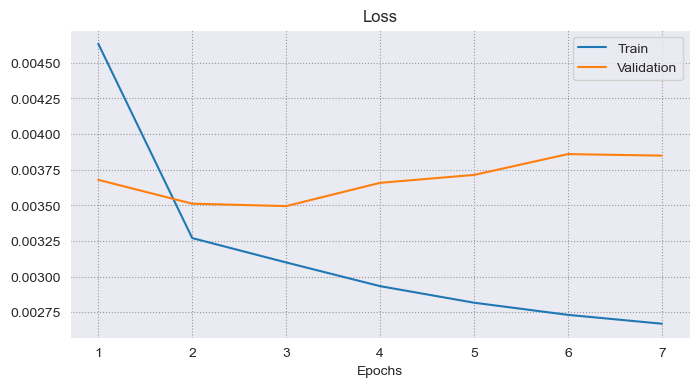

In [71]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.array(range(len(model.errs))) + 1
sns.lineplot(x=x, y=[float(e[0]) for e in model.errs], label="Train")
sns.lineplot(x=x, y=[float(e[1]) for e in model.errs], label="Validation")
ax.set_title("Loss")
ax.set_xlabel("Epochs")
plt.show()

In [72]:
# get model with lowest validation loss
val_loss = [float(e[1]) for e in model.errs]
best_version = np.argmin(val_loss) + 1

# delete current model from memory
clean_gpu_memory(model)

# load best model
model =  ResUnet(
    channel=in_channels,
    output_dim=1,
    filters=[16, 16, 16, 16]
).to(dev)
model.errs = []
model.load_state_dict(torch.load(f"model_checkpoint_{best_version}.pt"))

<All keys matched successfully>

In [106]:
best_version

3

# Test DataLoader

In [73]:
testloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches_sample_val, 
        frames_idx,
        county_data=county_data,
        ibama_data=ib_array,
        past_defor_data=past_grid
    ),
    batch_size=128,
    shuffle=True,
)

# Prediction example

In [74]:
def get_sample(min_area=0.1, dataloader=trainloader):
    for input_, truth in dataloader:
        batches = list(range(truth.shape[0]))
        shuffle(batches)
        for idx_batch in batches:
            if truth[idx_batch, :, :].mean() >= min_area:
                return input_, truth, idx_batch

In [75]:
sigmoid_fun = nn.Sigmoid()

In [76]:
input_, truth, idx_batch = get_sample(1e-3, testloader)

pred = sigmoid_fun(model(input_))[idx_batch, 0, :, :]
label = truth[idx_batch, :, :].cpu()

C:\Users\giovanni\AppData\Local\Temp\ipykernel_6024\946946456.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


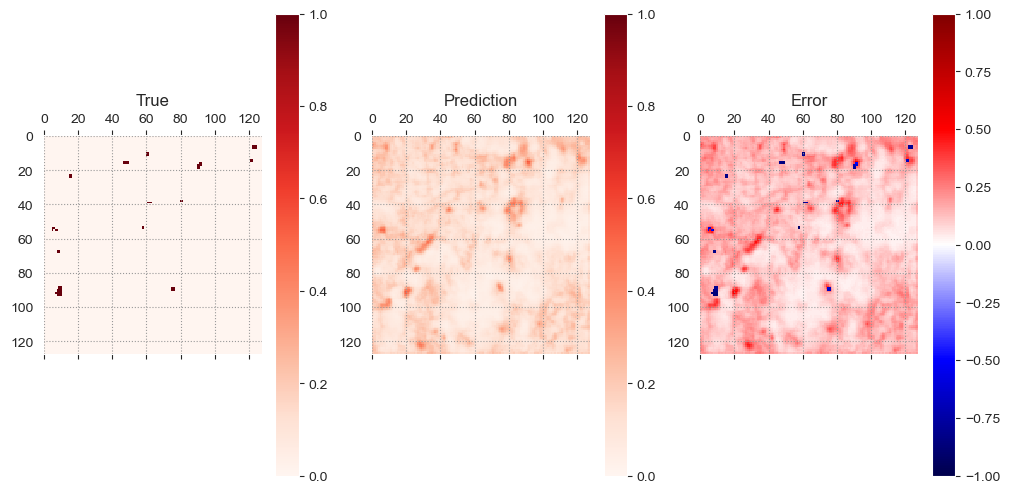

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
m1 = ax[0].matshow(label, cmap="Reds", vmin=0, vmax=1)
m2 = ax[1].matshow(pred.detach().cpu().numpy(), cmap="Reds", vmin=0, vmax=1)
m3 = ax[2].matshow(pred.detach().cpu().numpy() - label.cpu().numpy(), cmap="seismic", vmin=-1, vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.colorbar(m3)
ax[0].set_title("True")
ax[1].set_title("Prediction")
ax[2].set_title("Error")
fig.show()

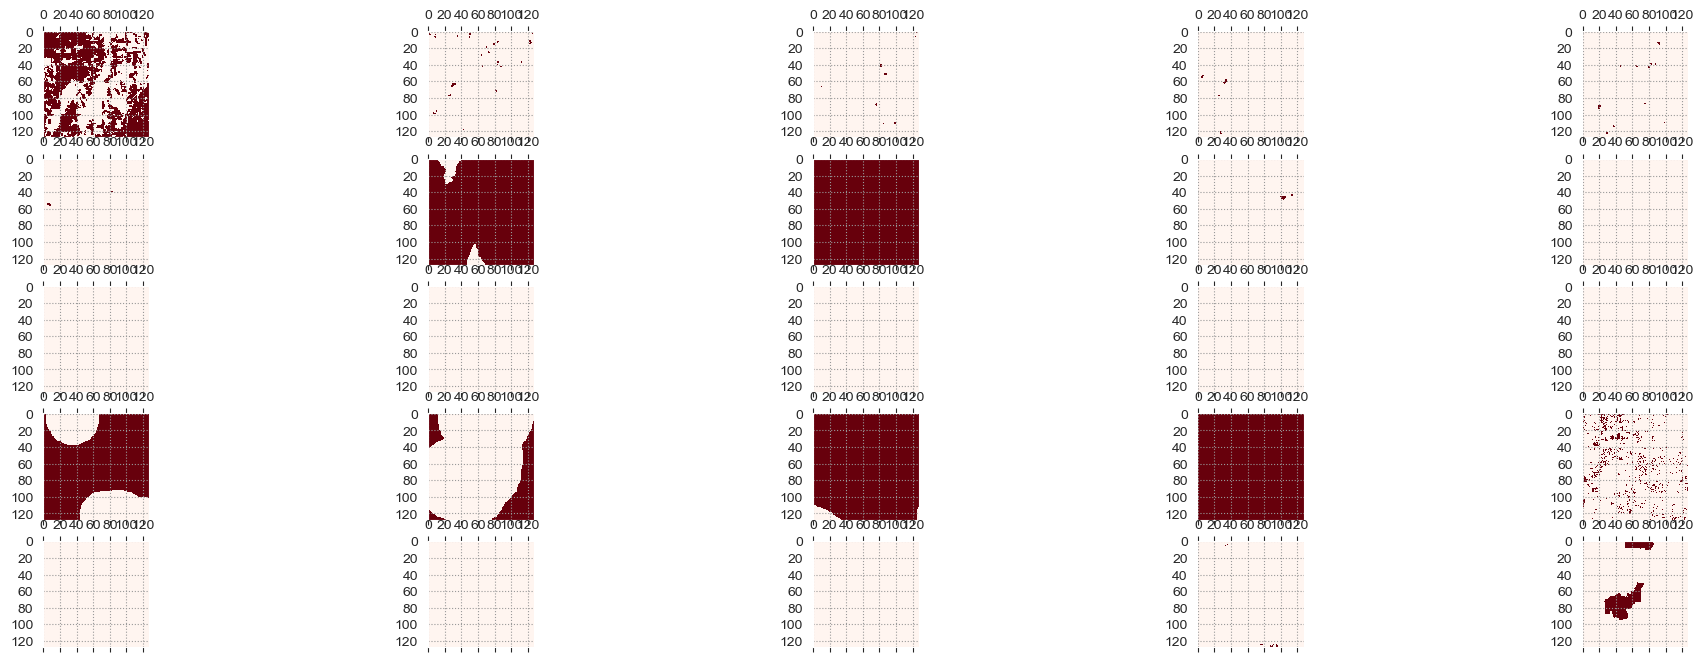

In [78]:
fig, ax = plt.subplots(5, 5, figsize=(24, 8))
for i in range(5):
    for j in range(5):
        ax[j, i].matshow(input_[idx_batch, i+5*j, :, :].cpu() > 0, cmap="Reds", vmin=truth.min(), vmax=truth.max())
plt.show()

# Treshold Selection

Use validation dataset to select the treshold that maximizes F1-score

In [79]:
pt_values = range(0, 101, 1)
val_p_cm = np.zeros((len(pt_values), 2, 2)).astype(int)
for inputs, labels in tqdm(valloader):
    # compute prediction (probability)
    p_hat = sigmoid_fun(model(inputs))[:, 0, :, :].detach().cpu().numpy().flatten()
    vals = labels[:, :, :].cpu().numpy().flatten()
    for i, ptresh in enumerate(pt_values):
        # for each treshold compute confusion matrix
        y_hat = p_hat >= ptresh / 100
        unique_0, counts_0 = np.unique(y_hat[np.where(vals == 0)], return_counts=True)
        unique_1, counts_1 = np.unique(y_hat[np.where(vals == 1)], return_counts=True)
        for (u, c) in zip(unique_0, counts_0):
            if u:  # pred True
                val_p_cm[i, 0, 1] += c
            else:
                val_p_cm[i, 0, 0] += c
        for (u, c) in zip(unique_1, counts_1):
            if u:
                val_p_cm[i, 1, 1] += c
            else:
                val_p_cm[i, 1, 0] += c

100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [18:30<00:00,  4.19s/it]


In [80]:
acc = (val_p_cm[:, 0, 0] + val_p_cm[:, 1, 1]) / val_p_cm.sum(axis=(1,2))
prc = val_p_cm[:, 1, 1] / val_p_cm[:, :, 1].sum(axis=1)
prc[np.where(prc!=prc)] = 1e-8
rcl = val_p_cm[:, 1, 1] / val_p_cm[:, 1, :].sum(axis=1)
f1 = 2 * prc * rcl / (prc + rcl)

C:\Users\giovanni\AppData\Local\Temp\ipykernel_6024\4033611214.py:2: RuntimeWarning: invalid value encountered in divide
  prc = val_p_cm[:, 1, 1] / val_p_cm[:, :, 1].sum(axis=1)
C:\Users\giovanni\AppData\Local\Temp\ipykernel_6024\4033611214.py:5: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prc * rcl / (prc + rcl)


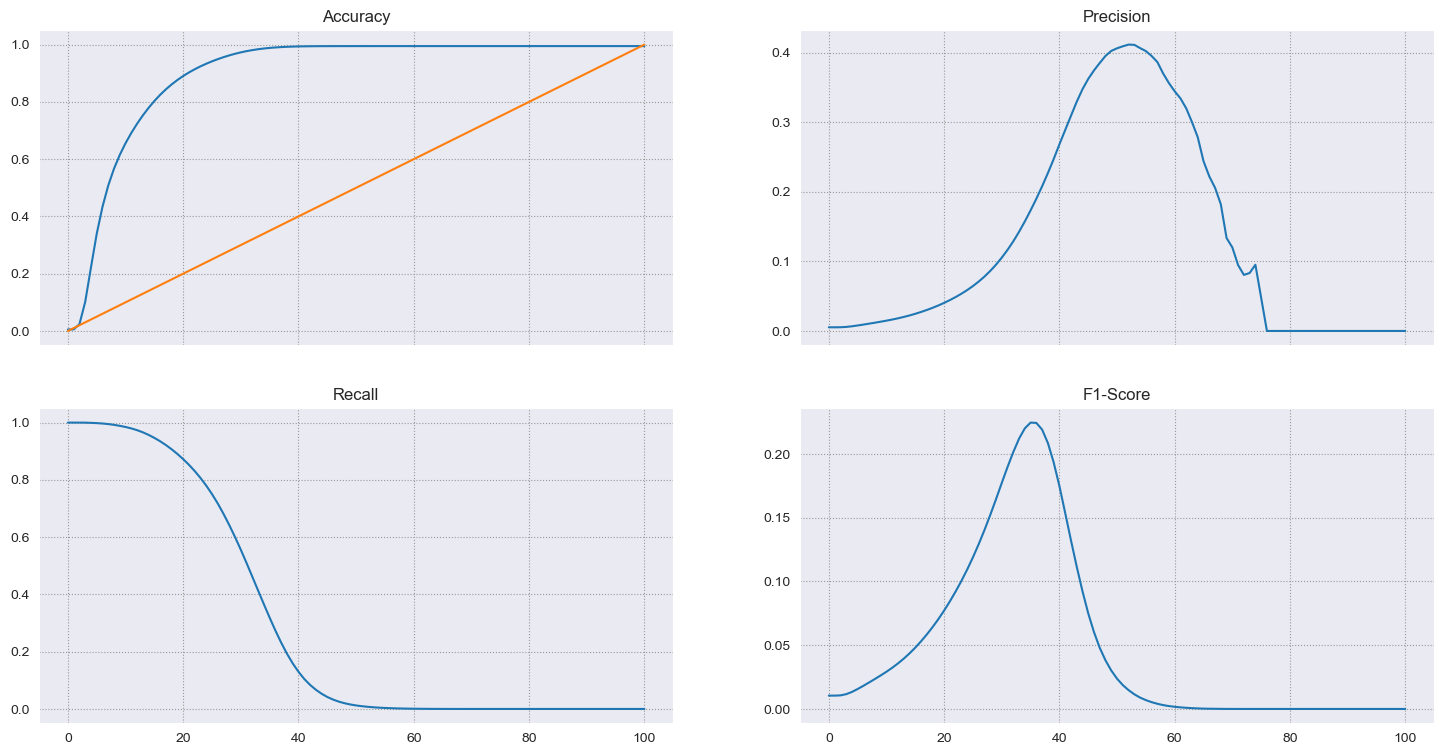

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(18, 9), sharex=True)
sns.lineplot(x=pt_values, y=acc, ax=ax[0, 0])
sns.lineplot(x=pt_values, y=prc, ax=ax[0, 1])
sns.lineplot(x=pt_values, y=rcl, ax=ax[1, 0])
sns.lineplot(x=pt_values, y=f1, ax=ax[1, 1])
ax[0,0].set_title("Accuracy")
ax[0,1].set_title("Precision")
ax[1,0].set_title("Recall")
ax[1,1].set_title("F1-Score")
sns.lineplot(x=[0,100], y=[0,1], ax=ax[0,0])
plt.show()

In [82]:
i_treshold = np.argmax(f1[f1>0])
ptreshold = pt_values[i_treshold]
ptreshold, f1[i_treshold], prc[i_treshold]

(35, 0.22459779952354594, 0.17340383334986045)

In [83]:
val_p_cm[i_treshold, :, :]

array([[547916326,   4434619],
       [  1988902,    930297]])

# Test Score

Apply chosen treshold and compute scores in test dataset

In [84]:
test_cm = np.zeros((2,2)).astype(int)
for inputs, labels in tqdm(testloader):
    pred = (sigmoid_fun(model(inputs)).detach() >= ptreshold / 100).cpu().numpy().flatten()
    vals = labels.cpu().numpy().flatten()
    unique_0, counts_0 = np.unique(pred[np.where(vals == 0)], return_counts=True)
    unique_1, counts_1 = np.unique(pred[np.where(vals == 1)], return_counts=True)
    for (u, c) in zip(unique_0, counts_0):
        if u:  # pred True
            test_cm[0, 1] += c
        else:
            test_cm[0, 0] += c
    for (u, c) in zip(unique_1, counts_1):
        if u:
            test_cm[1, 1] += c
        else:
            test_cm[1, 0] += c

100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [06:02<00:00,  1.30s/it]


In [85]:
acc_test = (test_cm[0, 0] + test_cm[1, 1]) / test_cm.sum()
prc_test = test_cm[1, 1] / test_cm[:, 1].sum()
rcl_test = test_cm[1, 1] / test_cm[1, :].sum()
f1_test = 2 * prc_test * rcl_test / (prc_test + rcl_test)

In [86]:
test_cm

array([[577433219,   4452586],
       [  1406380,    453351]])

In [87]:
acc_test, prc_test, rcl_test, f1_test

(0.9899631506561105,
 0.09240864691087554,
 0.24377235202295386,
 0.1340151482455243)

# Lower spatial granularity

Apply a spatial reduction to data, select new treshold (in validation) and evaluate in test.

In [89]:
import numpy as np
from scipy.ndimage import convolve

def apply_distance_threshold(arr, threshold):
    # Define a kernel that considers neighboring cells within the threshold distance
    kernel_size = 2 * threshold + 1
    kernel = np.ones((kernel_size, kernel_size))
    
    # Convolve the original array with the kernel
    convolved = convolve(arr, kernel, mode='constant', cval=0)
    
    # Apply threshold to the convolved array
    result = convolved > 0
    
    return result.astype(int)

def apply_distance_threshold_3d(arr_3d, threshold):
    result_3d = np.zeros_like(arr_3d)
    
    for i, arr_2d in enumerate(arr_3d):
        result_3d[i] = apply_distance_threshold(arr_2d, threshold)
    
    return result_3d

# Example usage
original_array_3d = np.array([[[0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0]],
                               
                               [[0, 0, 0, 1, 0],
                                [0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0]]])

threshold_distance = 1

result_array_3d = apply_distance_threshold_3d(original_array_3d, threshold_distance)
print(result_array_3d)

[[[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 1 1 1]
  [0 0 1 1 1]
  [0 0 1 1 1]]]


In [90]:
dims = [3, 5, 7, 9, 11]

## Select treshold by dimensionality

In [91]:
pt_values = list(range(15, 46))

In [92]:
val_pd_cm = np.zeros((len(dims), len(pt_values), 2, 2)).astype(int)
for inputs, labels in tqdm(valloader):
    # compute prediction (probability)
    p_hat = sigmoid_fun(model(inputs))[:, 0, :, :].detach().cpu().numpy()

    for idim, dim in enumerate(dims):
        dist = int(dim / 2)
        vals = labels[:, :, :].cpu().numpy()
        vals = apply_distance_threshold_3d(vals, dist).flatten()

        for i, ptresh in enumerate(pt_values):
            # for each treshold compute confusion matrix
            y_hat = p_hat >= ptresh / 100
            y_hat = apply_distance_threshold_3d(y_hat, dist).flatten()
            unique_0, counts_0 = np.unique(y_hat[np.where(vals == 0)], return_counts=True)
            unique_1, counts_1 = np.unique(y_hat[np.where(vals == 1)], return_counts=True)
            for (u, c) in zip(unique_0, counts_0):
                if u:  # pred True
                    val_pd_cm[idim, i, 0, 1] += c
                else:
                    val_pd_cm[idim, i, 0, 0] += c
            for (u, c) in zip(unique_1, counts_1):
                if u:
                    val_pd_cm[idim, i, 1, 1] += c
                else:
                    val_pd_cm[idim, i, 1, 0] += c

100%|██████████████████████████████████████████████████████████████████████████████| 265/265 [1:43:28<00:00, 23.43s/it]


In [93]:
acc_pd = (val_pd_cm[:, :, 0, 0] + val_pd_cm[:, :, 1, 1]) / val_pd_cm.sum(axis=(2,3))
prc_pd = val_pd_cm[:, :, 1, 1] / val_pd_cm[:, :, :, 1].sum(axis=2)
prc_pd[np.where(prc_pd!=prc_pd)] = 1e-8
rcl_pd = val_pd_cm[:, :, 1, 1] / val_pd_cm[:, :, 1, :].sum(axis=2)
f1_pd = 2 * prc_pd * rcl_pd / (prc_pd + rcl_pd)
f1_pd[np.where(f1_pd!=f1_pd)] = 1e-8

In [94]:
itresh_by_dim = np.argmax(f1_pd, axis=1)

In [95]:
ptresh_by_dim = [pt_values[i] for i in itresh_by_dim]

In [96]:
for idim in range(len(dims)):
    print(dims[idim])
    print(ptresh_by_dim[idim])
    print(val_pd_cm[idim, itresh_by_dim[idim], :, :])
    print(f1_pd[idim, itresh_by_dim[idim]])
    print()

3
34
[[532945452  10985003]
 [  5998171   5341518]]
0.3861402049648289

5
33
[[515474810  18119353]
 [  9178095  12497886]]
0.4779925963633526

7
32
[[497265637  25499537]
 [ 11194523  21310447]]
0.5373626516886084

9
32
[[483087000  28905675]
 [ 13758716  29518753]]
0.5804956224169546

11
32
[[469702984  31765533]
 [ 15996756  37804871]]
0.612859668331147



## Evaluate on test

In [97]:
test_d_cm = np.zeros((len(dims), 2, 2)).astype(int)
for inputs, labels in tqdm(testloader):
    # compute prediction (probability)
    p_hat = sigmoid_fun(model(inputs))[:, 0, :, :].detach().cpu().numpy()

    for idim, dim in enumerate(dims):
        dist = int(dim / 2)
        vals = labels[:, :, :].cpu().numpy()
        vals = apply_distance_threshold_3d(vals, dist).flatten()

        ptresh = ptresh_by_dim[idim]
        y_hat = p_hat >= ptresh / 100
        y_hat = apply_distance_threshold_3d(y_hat, dist).flatten()
        unique_0, counts_0 = np.unique(y_hat[np.where(vals == 0)], return_counts=True)
        unique_1, counts_1 = np.unique(y_hat[np.where(vals == 1)], return_counts=True)
        for (u, c) in zip(unique_0, counts_0):
            if u:  # pred True
                test_d_cm[idim, 0, 1] += c
            else:
                test_d_cm[idim, 0, 0] += c
        for (u, c) in zip(unique_1, counts_1):
            if u:
                test_d_cm[idim, 1, 1] += c
            else:
                test_d_cm[idim, 1, 0] += c

100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [12:13<00:00,  2.63s/it]


In [98]:
acc_d = (test_d_cm[:, 0, 0] + test_d_cm[:, 1, 1]) / test_d_cm.sum(axis=(1,2))
prc_d = test_d_cm[:, 1, 1] / test_d_cm[:, :, 1].sum(axis=1)
prc_d[np.where(prc_d!=prc_d)] = 1e-8
rcl_d = test_d_cm[:, 1, 1] / test_d_cm[:, 1, :].sum(axis=1)
f1_d = 2 * prc_d * rcl_d / (prc_d + rcl_d)

In [99]:
f1_d

array([0.26806614, 0.35891125, 0.42850761, 0.48333501, 0.52718451])

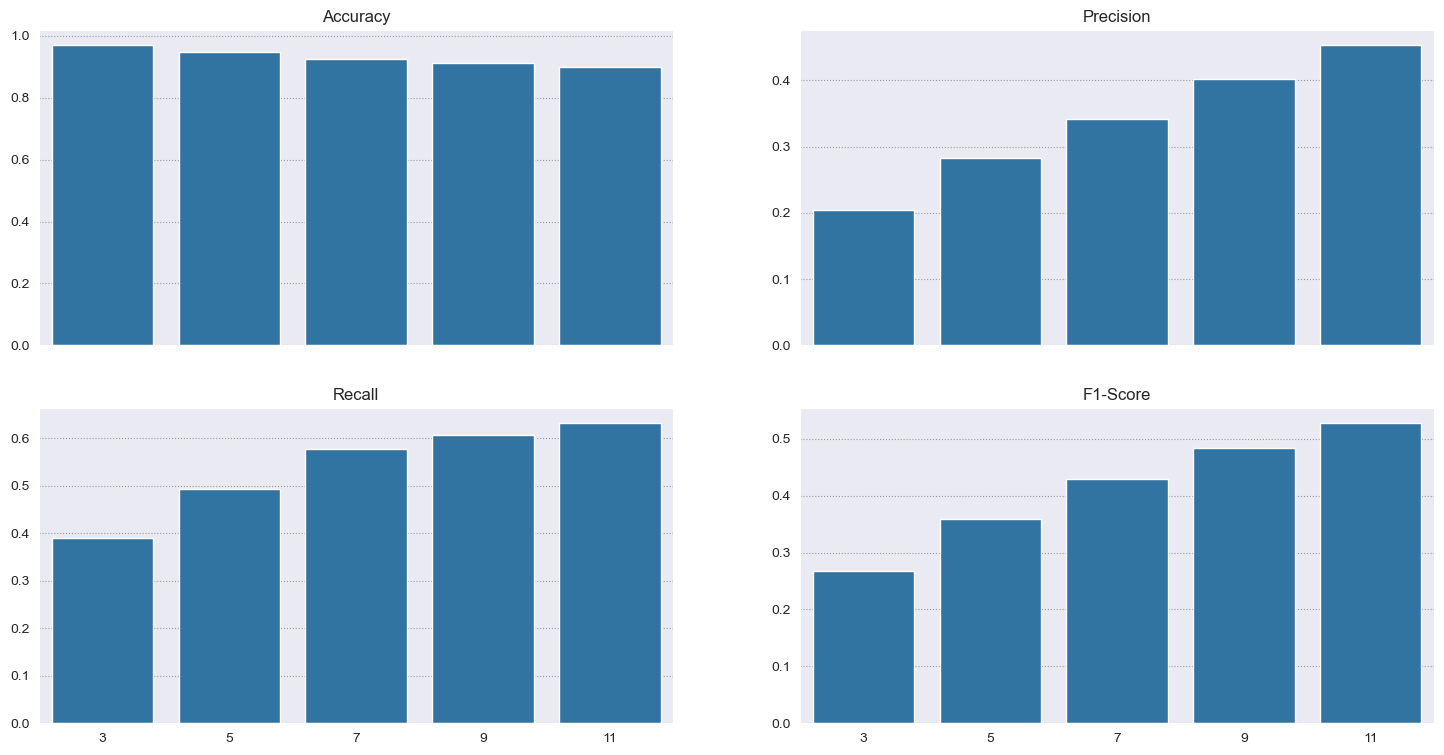

In [100]:
fig, ax = plt.subplots(2, 2, figsize=(18, 9), sharex=True)
sns.barplot(x=dims, y=acc_d, ax=ax[0, 0], color=sns.color_palette()[0])
sns.barplot(x=dims, y=prc_d, ax=ax[0, 1], color=sns.color_palette()[0])
sns.barplot(x=dims, y=rcl_d, ax=ax[1, 0], color=sns.color_palette()[0])
sns.barplot(x=dims, y=f1_d, ax=ax[1, 1], color=sns.color_palette()[0])
ax[0,0].set_title("Accuracy")
ax[0,1].set_title("Precision")
ax[1,0].set_title("Recall")
ax[1,1].set_title("F1-Score")
plt.show()

# Save model and results

In [101]:
import os
from datetime import datetime

In [102]:
nowtimestr = datetime.strftime(datetime.now(), format="%Y%m%d%H%M%S")
dirnm = f"{FUTURE_WINDOW_PRED}_{nowtimestr}"
os.mkdir(dirnm)

# save model
torch.save(model.state_dict(), os.path.join(dirnm, r"resunet_class_0.01.pt"))

In [103]:
result_str = f"""
PREDICTION WINDOW (WEEKS): {FUTURE_WINDOW_PRED}

BEST TRESHOLD: {ptreshold}
CONFUSION MATRIX[0,0]: {test_cm[0,0]}
CONFUSION MATRIX[0,1]: {test_cm[0,1]}
CONFUSION MATRIX[1,0]: {test_cm[1,0]}
CONFUSION MATRIX[1,1]: {test_cm[1,1]}
F1-SCORE (TEST): {f1_test}
AUGMENTED DIMENSION SIZES: {list(dims)}
"""

for idim, dim in enumerate(dims):
    result_str += f"""
    FOR AUG SPATIAL DIM: {dim}
    BEST TRESHOLD: {ptresh_by_dim[idim]}
    CONFUSION MATRIX[0,0]: {test_d_cm[idim, 0,0]}
    CONFUSION MATRIX[0,1]: {test_d_cm[idim, 0,1]}
    CONFUSION MATRIX[1,0]: {test_d_cm[idim, 1,0]}
    CONFUSION MATRIX[1,1]: {test_d_cm[idim, 1,1]}
    F1-SCORE (TEST): {f1_d[idim]}
    """

In [104]:
print(result_str)


PREDICTION WINDOW (WEEKS): 12

BEST TRESHOLD: 35
CONFUSION MATRIX[0,0]: 577433219
CONFUSION MATRIX[0,1]: 4452586
CONFUSION MATRIX[1,0]: 1406380
CONFUSION MATRIX[1,1]: 453351
F1-SCORE (TEST): 0.1340151482455243
AUGMENTED DIMENSION SIZES: [3, 5, 7, 9, 11]

    FOR AUG SPATIAL DIM: 3
    BEST TRESHOLD: 34
    CONFUSION MATRIX[0,0]: 562806699
    CONFUSION MATRIX[0,1]: 12626778
    CONFUSION MATRIX[1,0]: 5071177
    CONFUSION MATRIX[1,1]: 3240882
    F1-SCORE (TEST): 0.2680661425387119
    
    FOR AUG SPATIAL DIM: 5
    BEST TRESHOLD: 33
    CONFUSION MATRIX[0,0]: 544347093
    CONFUSION MATRIX[0,1]: 21938691
    CONFUSION MATRIX[1,0]: 8843189
    CONFUSION MATRIX[1,1]: 8616563
    F1-SCORE (TEST): 0.35891125370264454
    
    FOR AUG SPATIAL DIM: 7
    BEST TRESHOLD: 32
    CONFUSION MATRIX[0,0]: 524272900
    CONFUSION MATRIX[0,1]: 31324728
    CONFUSION MATRIX[1,0]: 11931172
    CONFUSION MATRIX[1,1]: 16216736
    F1-SCORE (TEST): 0.4285076113460156
    
    FOR AUG SPATIAL DIM: 9
   

In [105]:
with open(os.path.join(dirnm, "results.txt"), "w") as file:
    file.write(result_str)